In [71]:
import pandas as pd
import numpy as np
from sklearn.neighbors import BallTree
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler, MinMaxScaler

## Categorización de Tipos de Negocios

En esta sección se clasifica cada negocio en una categoría general a partir del contenido de su tipo (`tipo_negocio`). Esto permite agrupar los negocios en sectores más amplios y útiles para el análisis.

Se siguen los siguientes pasos:

1. **Cargar el CSV original** con los datos de los negocios.
2. **Definir una función de categorización** que analiza palabras clave dentro del tipo de negocio.
3. **Aplicar la función** a cada fila del dataset para generar una nueva columna `categoria_negocio`.
4. **Guardar el resultado** en un nuevo archivo CSV.

## Refinamiento de la Categorización mediante el Nombre del Negocio

Después de realizar una categorización inicial basada en el tipo (`tipo_negocio`), muchos registros aún quedan clasificados como "Otros / No categorizado". Para mejorar la calidad del etiquetado, se realiza una segunda pasada utilizando el contenido del campo `nombre`.

Esta estrategia permite detectar patrones frecuentes en los nombres (como "bar", "peluquería", "taller", etc.) y reclasificar adecuadamente esos negocios en categorías más precisas.

Este refinamiento puede mejorar hasta un 20% de los casos inicialmente no categorizados, incrementando así la utilidad del análisis posterior.

## Filtrado de Negocios según Relevancia

Para asegurar que el análisis se base en datos representativos y confiables, se aplican dos criterios de limpieza:

- Se eliminan aquellos negocios que no tienen puntuación media (`NaN`).
- Se excluyen los negocios con menos

## Feature engineering avanzado

En esta sección enriquecemos el dataset con tres nuevas columnas que capturan señal geoespacial:

1. **Distancia al centro de la ciudad**  
2. **Densidad de locales en un radio de 1 km**  
3. **Clusterización espacial (DBSCAN)**

## Cálculo de Valoración Ajustada

Para obtener una medida más realista de la calidad de cada negocio, se calcula una **valoración ajustada** que tiene en cuenta tanto la puntuación media como el número de reseñas.

La fórmula utilizada penaliza a los negocios con pocas valoraciones, reduciendo la confianza en sus puntuaciones altas o bajas. Así se evita sobrevalorar negocios con una única review excelente, por ejemplo.

La fórmula aplicada es:

## Normalización de la Valoración por Categoría

Para poder comparar de forma justa las valoraciones entre negocios de una misma categoría, se realiza una **normalización Min-Max** dentro de cada grupo de `categoria_negocio`.

Esto escala los valores de la columna `valoracion` al rango [0, 1], pero de forma **independiente por categoría**, conservando la proporcionalidad interna y permitiendo comparaciones relativas dentro de cada grupo.

> 📈 Esta normalización es útil para visualizaciones comparativas y para entrenar modelos que se benefician de variables en un mismo rango.

In [72]:
import pandas as pd
import numpy as np

df = pd.read_csv("../data/locales.csv")
print(df.columns.tolist())

['nombre', 'direccion', 'codigo_postal', 'puntuacion_media', 'numero_reviews', 'tipo_negocio', 'latitud', 'longitud']


In [73]:
# Limpiar duplicados considerando el código postal como diferenciador
columnas_clave = ['nombre', 'direccion', 'tipo_negocio']
duplicados = df.duplicated(subset=columnas_clave, keep='first')
total_duplicados = duplicados.sum()
print(f"Total de duplicados encontrados: {total_duplicados}")

df = df[~duplicados]
print("Duplicados eliminados. Continuamos con el preprocesado.")

Total de duplicados encontrados: 1025
Duplicados eliminados. Continuamos con el preprocesado.


In [74]:
# Revisar algunos duplicados para decidir
duplicados = df[df.duplicated(subset=['nombre', 'direccion', 'tipo_negocio'], keep=False)]
print(duplicados.sort_values(['nombre', 'direccion']))

Empty DataFrame
Columns: [nombre, direccion, codigo_postal, puntuacion_media, numero_reviews, tipo_negocio, latitud, longitud]
Index: []


In [75]:
import pandas as pd

df = pd.read_csv("../data/locales.csv")

def categorizar_negocio(tipo_str):
    tipo_str = str(tipo_str).lower()
    if any(t in tipo_str for t in ['restaurant', 'food', 'bar', 'cafe', 'bakery', 'meal_takeaway', "night_club"]):
        return 'Restauración'
    elif any(t in tipo_str for t in ['lodging', 'hotel', 'hostel', 'guest_house']):
        return 'Alojamiento'
    elif any(t in tipo_str for t in ['church', 'place_of_worship', 'mosque', 'synagogue', 'hindu_temple']):
        return 'Religión / Culto'
    elif any(t in tipo_str for t in ['locality', 'police', 'political', 'city_hall', 'post_office', 'courthouse', 'embassy', 'local_government_office']):
        return 'Administración / Localidad'
    elif any(t in tipo_str for t in ['store', 'shopping_mall', 'travel_agency', 'lawyer', 'hair_care', 'bank', 'car_repair', 'laundry', 'gym', 'pharmacy', 'doctor', 'real_estate_agency']):
        return 'Comercio / Servicios'
    elif any(t in tipo_str for t in ['school', 'IES', 'Instituto', 'university', 'secondary_school', 'primary_school', 'library']):
        return 'Educación'
    elif any(t in tipo_str for t in ['health']):
        return 'Salud'
    elif any(t in tipo_str for t in ['finance', 'insurance_agency']):
        return 'Finanzas y Seguros'
    elif any(t in tipo_str for t in ['general_contractor']):
        return 'Construcción / Reformas'
    elif any(t in tipo_str for t in ['park']):
        return 'Naturaleza / Recreación'
    elif any(t in tipo_str for t in ['tourist_attraction', 'Auditorio', 'auditorium', 'stadium','museum', 'museo', 'movie_theater', 'teatro', 'cine', 'cinema']):
        return 'Turismo / Atracción'
    else:
        return 'Otros / No categorizado'
  
df['categoria_negocio'] = df['tipo_negocio'].apply(categorizar_negocio)

In [76]:
def clasificar_por_nombre(nombre, tipo_actual):
    nombre = str(nombre).lower()
    if tipo_actual == 'Otros / No categorizado':
        if 'bar' in nombre: return 'Restauración'
        if 'peluquería' in nombre or 'hair' in nombre or 'gym' in nombre or 'fitness' in nombre or 'polideportivo' in nombre or 'deporte' in nombre or 'deportivo' in nombre: return 'Comercio / Servicios'
        if 'taller' in nombre or 'auto' in nombre or 'arquitectos' in nombre or 'construction' in nombre or 'contractor' in nombre or 'reformas' in nombre or 'ingeneria' in nombre: return 'Comercio / Servicios'
        if 'teatro' in nombre or 'auditorio' in nombre or 'theatre' in nombre or 'auditorium' in nombre or 'stadium' in nombre: return "Turismo / Atracción"
        if 'parque' in nombre: return "Naturaleza / Recreación"
        if 'museo' in nombre: return "Turismo / Atracción"
        if 'zoológico' in nombre: return "Naturaleza / Recreación"
        if 'university' in nombre or 'universidad' in nombre or 'IES' in nombre or 'Academy' in nombre: return "Educación"
        if 'hospital' in nombre or 'salud' in nombre or 'health' in nombre or 'medicina' in nombre or 'medical' in nombre or 'healthcare' in nombre or 'clinic' in nombre or 'centro de salud' in nombre or 'doctor' in nombre: return "Salud"
        if 'finanzas' in nombre or 'banco' in nombre: return "Finanzas y Seguros"
        if 'contratista' in nombre: return "Construcción / Reformas"
        if 'comisaria' in nombre or 'policia' in nombre: return "Administración / Localidad"
        if 'religiosas' in nombre or 'religion' in nombre or 'iglesia' in nombre or 'church' in nombre or 'cristo' in nombre: return "Religión / Culto"

    return tipo_actual

df['categoria_negocio'] = df.apply(lambda row: clasificar_por_nombre(row['nombre'], row['categoria_negocio']), axis=1)

In [77]:
pd.set_option('display.max_rows', None)


In [78]:
len(df[df.categoria_negocio == "Otros / No categorizado"])

511

In [79]:
df[df.categoria_negocio == "Otros / No categorizado"]

,nombre,direccion,codigo_postal,puntuacion_media,numero_reviews,tipo_negocio,latitud,longitud,categoria_negocio
42,Fundación Carolina,"Plaza del Marqués de Salamanca, 8, 4°, Madrid",28001,4.4,18.0,"point_of_interest, establishment",40.430524,-3.679170,Otros / No categorizado
73,Enforex Camps,"Calle de Gustavo Fernández Balbuena, 11, 2º pl...",28002,4.5,201.0,"point_of_interest, establishment",40.449653,-3.667895,Otros / No categorizado
84,Acalaca Selección,"Calle de Luis de Salazar, 6, Madrid",28002,4.1,122.0,"point_of_interest, establishment",40.447248,-3.667030,Otros / No categorizado
95,Encuestas Remuneradas,"Calle de San Julio, 5, Madrid",28002,1.0,1.0,"point_of_interest, establishment",40.442029,-3.680597,Otros / No categorizado
99,Los Gemelos,"Calle de López de Hoyos, 123, Madrid",28002,4.2,302.0,"point_of_interest, establishment",40.446254,-3.671091,Otros / No categorizado
102,"Micro Aire, S.L.","Calle de Víctor de la Serna, 5, Madrid",28002,4.4,441.0,"point_of_interest, establishment",40.452678,-3.673430,Otros / No categorizado
116,Be-Up,"Calle de Gustavo Fernández Balbuena, 11, Loft ...",28002,5.0,2.0,"point_of_interest, establishment",40.449708,-3.667915,Otros / No categorizado
118,Cambridge House,"Calle de López de Hoyos, 95, Madrid",28002,4.9,128.0,"point_of_interest, establishment",40.445131,-3.672854,Otros / No categorizado
119,AEG ZANUSSI ELECTROLUX Repuestos y Reparaciones,"Calle Cardenal Siliceo, 7 PROSPERIDAD, CHAMART...",28002,4.2,124.0,"point_of_interest, establishment",40.445121,-3.671193,Otros / No categorizado
155,Fundación Residencia de Estudiantes,"Calle del Pinar, 21-23, Madrid",28003,4.5,1280.0,"point_of_interest, establishment",40.440676,-3.687950,Otros / No categorizado


In [80]:
# Codificación numérica de categorías para uso en modelos
df['categoria_id'] = df['categoria_negocio'].astype('category').cat.codes

In [81]:
df = df[df['puntuacion_media'].notna() & (df['numero_reviews'] >= 3)]

In [82]:
from sklearn.neighbors import BallTree
import numpy as np

# Convertir coordenadas a radianes
coords_rad = np.deg2rad(df[['latitud', 'longitud']].values)

# Crear árbol espacial con distancia haversine
tree = BallTree(coords_rad, metric='haversine')

# Definir radios de búsqueda en kilómetros
radios_km = [0.5, 1.0, 2.0]

# Calcular densidad para cada radio
for r_km in radios_km:
    columna = f'density_{int(r_km * 1000)}m'
    radio_en_radianes = r_km / 6371.0
    df[columna] = tree.query_radius(coords_rad, r=radio_en_radianes, count_only=True)

# Calcular ratio de competencia: 500m frente a 2km
if 'density_500m' in df.columns and 'density_2000m' in df.columns:
    df['ratio_500m_2km'] = df['density_500m'] / (df['density_2000m'] + 1)
else:
    print("⚠️ Columnas de densidad no encontradas, no se pudo calcular el ratio.")

# Mostrar preview
df[['density_500m', 'density_1000m', 'density_2000m', 'ratio_500m_2km']].head()

,density_500m,density_1000m,density_2000m,ratio_500m_2km
1,55,163,682,0.080527
2,45,161,577,0.077855
3,40,174,563,0.070922
4,54,160,676,0.079764
5,33,151,540,0.060998


In [83]:
# --- Feature Engineering Avanzado ---
from haversine import haversine
from sklearn.neighbors import BallTree
from sklearn.cluster import DBSCAN
import numpy as np

# Definir centro de ciudad (ejemplo: Madrid centro)
city_center = (40.4168, -3.7038)

# 1) Distancia al centro en km
df['dist_city_center_km'] = df.apply(
    lambda r: haversine((r.latitud, r.longitud), city_center),
    axis=1
)

# 2) Densidad de locales en un radio de 1 km
coords_rad = np.deg2rad(df[['latitud','longitud']].values)
tree = BallTree(coords_rad, metric='haversine')
radius = 1/6371.0  # radio de 1 km en radianes
df['local_density_1km'] = tree.query_radius(coords_rad, r=radius, count_only=True)

# 3) Clusterización geográfica con DBSCAN
db = DBSCAN(eps=0.5/6371.0, min_samples=10, metric='haversine')
df['cluster_zone'] = db.fit_predict(coords_rad).astype(str)

# Revisión de las nuevas columnas
df[['dist_city_center_km','local_density_1km','cluster_zone']].head()

,dist_city_center_km,local_density_1km,cluster_zone
1,1.618243,163,0
2,1.973073,161,0
3,1.972295,174,0
4,1.643555,160,0
5,2.008330,151,0


In [84]:
# --- Transformaciones polinómicas e interacciones ---
from sklearn.preprocessing import PolynomialFeatures

# Seleccionamos dos features numéricas para expandir
poly_feats = ['dist_city_center_km', 'density_1000m']
poly = PolynomialFeatures(degree=2, include_bias=False)

# Generar nuevas features
arr = poly.fit_transform(df[poly_feats])
names = poly.get_feature_names_out(poly_feats)
poly_df = pd.DataFrame(arr, columns=names, index=df.index)

# Concatenar con el DataFrame principal
df = pd.concat([df, poly_df], axis=1)

# Ejemplo de nuevas columnas
df[names].head()

,dist_city_center_km,dist_city_center_km,density_1000m,density_1000m,dist_city_center_km^2,dist_city_center_km density_1000m,density_1000m^2
1,1.618243,1.618243,163,163.0,2.618712,263.773683,26569.0
2,1.973073,1.973073,161,161.0,3.893019,317.664828,25921.0
3,1.972295,1.972295,174,174.0,3.889947,343.179315,30276.0
4,1.643555,1.643555,160,160.0,2.701274,262.968844,25600.0
5,2.008330,2.008330,151,151.0,4.033388,303.257779,22801.0


In [85]:
import numpy as np

df['valoracion'] = df.apply(
    lambda row: row['puntuacion_media'] * (1 - np.exp(-row['numero_reviews'] / 10)), axis=1
)

In [86]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_values = scaler.fit_transform(df[['puntuacion_media', 'numero_reviews']])

# Asignar cada columna individualmente
df['puntuacion_std'] = scaled_values[:, 0]
df['reviews_std'] = scaled_values[:, 1]

In [87]:
# Clasificar locales según número de reseñas
df['reviews_bin'] = pd.cut(
    df['numero_reviews'],
    bins=[0, 10, 50, 200, float('inf')],
    labels=['muy_pocos', 'pocos', 'normal', 'muchos']
)

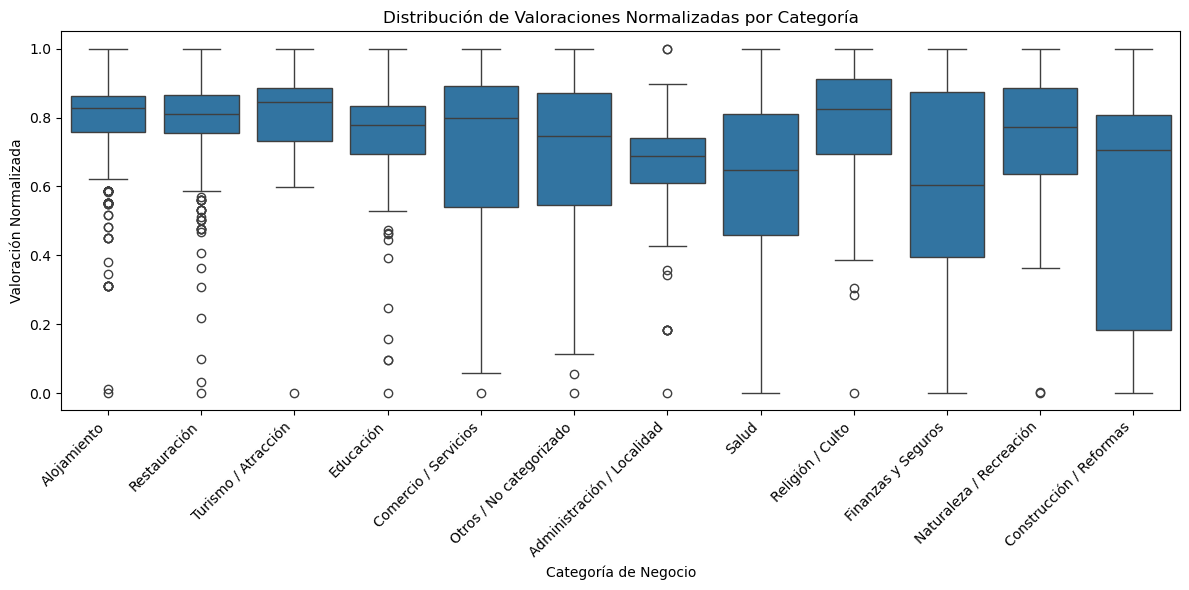

In [88]:
from sklearn.preprocessing import MinMaxScaler

df['valoracion_norm'] = df.groupby('categoria_negocio')['valoracion'].transform(
    lambda x: MinMaxScaler().fit_transform(x.values.reshape(-1, 1)).flatten()
)

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='categoria_negocio', y='valoracion_norm')
plt.xticks(rotation=45, ha='right')
plt.title('Distribución de Valoraciones Normalizadas por Categoría')
plt.xlabel('Categoría de Negocio')
plt.ylabel('Valoración Normalizada')
plt.tight_layout()
plt.show()

In [89]:
print(df.columns)

Index(['nombre', 'direccion', 'codigo_postal', 'puntuacion_media',
       'numero_reviews', 'tipo_negocio', 'latitud', 'longitud',
       'categoria_negocio', 'categoria_id', 'density_500m', 'density_1000m',
       'density_2000m', 'ratio_500m_2km', 'dist_city_center_km',
       'local_density_1km', 'cluster_zone', 'dist_city_center_km',
       'density_1000m', 'dist_city_center_km^2',
       'dist_city_center_km density_1000m', 'density_1000m^2', 'valoracion',
       'puntuacion_std', 'reviews_std', 'reviews_bin', 'valoracion_norm'],
      dtype='object')


In [90]:
# Eliminar columnas duplicadas
df = df.loc[:, ~df.columns.duplicated()]

# Asegurar que 'dist_city_center_km' es numérica
df['dist_city_center_km'] = pd.to_numeric(df['dist_city_center_km'], errors='coerce')

# Eliminar filas sin coordenadas válidas
df = df.dropna(subset=['dist_city_center_km'])

In [91]:
# Nueva interacción: cercanía al centro ponderada por valoración
df['valoracion_por_cercania'] = df['valoracion'] / (df['dist_city_center_km'] + 0.1)

In [92]:
# Revisión rápida de posibles valores extremos
df.describe().T[['min', 'max']]

,min,max
codigo_postal,28001.000000,28055.000000
puntuacion_media,1.000000,5.000000
numero_reviews,3.000000,199033.000000
latitud,40.321772,40.542087
longitud,-3.812423,-3.543879
categoria_id,0.000000,11.000000
density_500m,1.000000,185.000000
density_1000m,1.000000,355.000000
density_2000m,5.000000,706.000000
ratio_500m_2km,0.005682,0.731707


In [93]:
import os
os.makedirs("../data", exist_ok=True)

# Guardar el DataFrame con todos los datos ya preparados
df.to_csv("../data/locales_procesado.csv", index=False)

print("✅ Dataset final guardado en: ../data/locales_procesado.csv")

✅ Dataset final guardado en: ../data/locales_procesado.csv


## Análisis de Distribuciones y Outliers

A continuación se presentan tres visualizaciones clave para evaluar la calidad y comportamiento de las variables generadas:

- **Distribución de `valoracion`**: muestra la frecuencia de valoraciones asignadas a los locales. Se observa una concentración entre 3.5 y 4.5, con algunos valores bajos (< 1) que podrían requerir revisión si se espera una escala entre 1 y 5.

- **Distribución de `valoracion_por_cercania`**: refleja cómo se comporta la valoración ajustada por cercanía al centro. La mayoría de los valores están por debajo de 5, pero hay outliers significativos por encima de 15.

- **Gráfico de dispersión entre `valoracion_por_cercania` y `dist_city_center_km`**: permite observar que las valoraciones por cercanía más elevadas se concentran principalmente en los locales ubicados a menos de 1 km del centro de Madrid, lo que valida la lógica de la variable.

Estas visualizaciones ayudan a identificar posibles outliers o valores atípicos que podrían influir de forma significativa en modelos predictivos, y permiten tomar decisiones sobre normalización, winsorizing o transformación logarítmica.

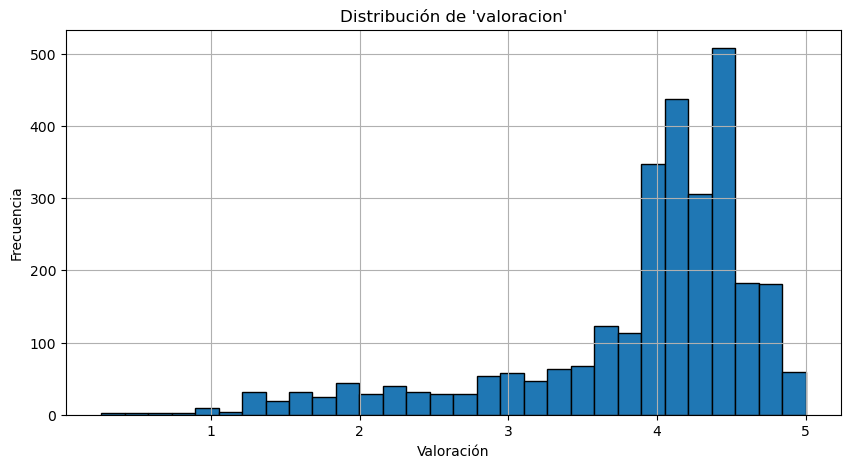

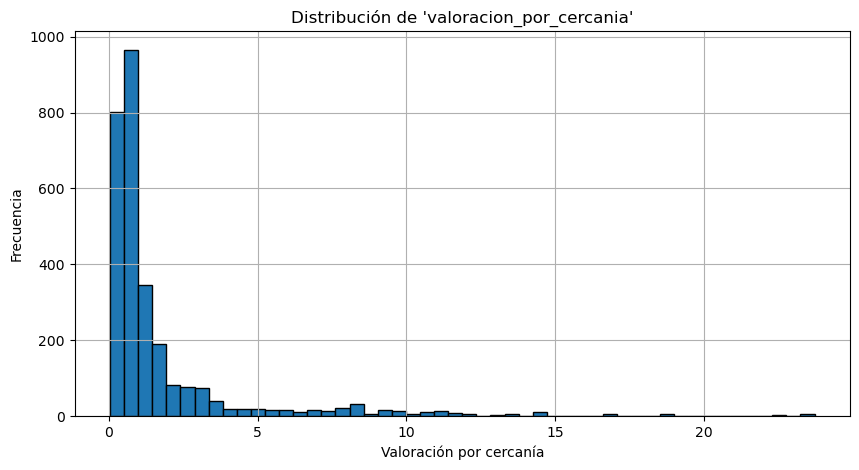

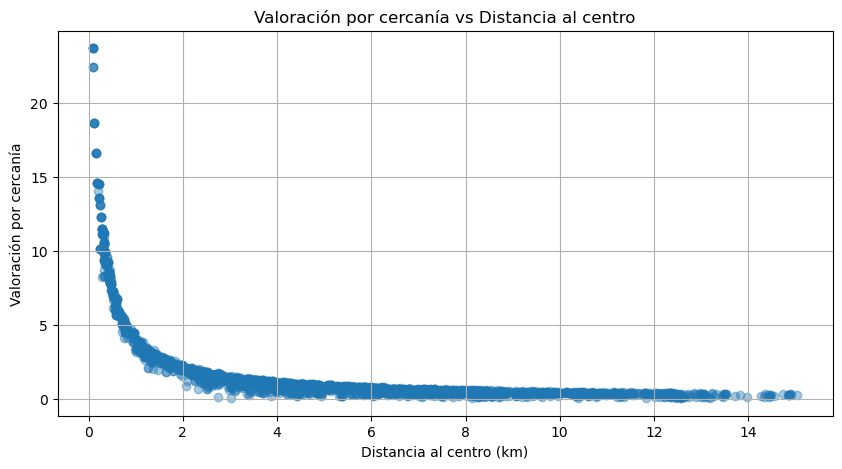

In [94]:
import matplotlib.pyplot as plt

# --- Distribución de 'valoracion' ---
plt.figure(figsize=(10, 5))
plt.hist(df["valoracion"], bins=30, edgecolor="black")
plt.title("Distribución de 'valoracion'")
plt.xlabel("Valoración")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.show()

# --- Distribución de 'valoracion_por_cercania' ---
plt.figure(figsize=(10, 5))
plt.hist(df["valoracion_por_cercania"], bins=50, edgecolor="black")
plt.title("Distribución de 'valoracion_por_cercania'")
plt.xlabel("Valoración por cercanía")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.show()

# --- Dispersión: valoración_por_cercania vs dist_city_center_km ---
plt.figure(figsize=(10, 5))
plt.scatter(df["dist_city_center_km"], df["valoracion_por_cercania"], alpha=0.4)
plt.title("Valoración por cercanía vs Distancia al centro")
plt.xlabel("Distancia al centro (km)")
plt.ylabel("Valoración por cercanía")
plt.grid(True)
plt.show()